# Supervised Learning: Solving Regression Problems Challenge

In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.model_selection import cross_val_score


# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

## Load Houseprices Dataset

In [166]:
# connect to Thinkful database to load houseprices dataset
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houseprices = pd.read_sql_query('select * from houseprices',con=engine)

# close connection
engine.dispose()

# check first 5 rows
houseprices.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


## Data Cleaning

In [167]:
houseprices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [168]:
houseprices.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000,1460.000,1201.000,1460.000,1460.000,1460.000,1460.000,1460.000,1452.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1379.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000
mean,730.500,56.897,70.050,10516.828,6.099,5.575,1971.268,1984.866,103.685,443.640,46.549,567.240,1057.429,1162.627,346.992,5.845,1515.464,0.425,0.058,1.565,0.383,2.866,1.047,6.518,0.613,1978.506,1.767,472.980,94.245,46.660,21.954,3.410,15.061,2.759,43.489,6.322,2007.816,180921.196
std,421.610,42.301,24.285,9981.265,1.383,1.113,30.203,20.645,181.066,456.098,161.319,441.867,438.705,386.588,436.528,48.623,525.480,0.519,0.239,0.551,0.503,0.816,0.220,1.625,0.645,24.690,0.747,213.805,125.339,66.256,61.119,29.317,55.757,40.177,496.123,2.704,1.328,79442.503
min,1.000,20.000,21.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,0.000,0.000,0.000,334.000,0.000,0.000,334.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000,1900.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000,34900.000
25%,365.750,20.000,59.000,7553.500,5.000,5.000,1954.000,1967.000,0.000,0.000,0.000,223.000,795.750,882.000,0.000,0.000,1129.500,0.000,0.000,1.000,0.000,2.000,1.000,5.000,0.000,1961.000,1.000,334.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,2007.000,129975.000
50%,730.500,50.000,69.000,9478.500,6.000,5.000,1973.000,1994.000,0.000,383.500,0.000,477.500,991.500,1087.000,0.000,0.000,1464.000,0.000,0.000,2.000,0.000,3.000,1.000,6.000,1.000,1980.000,2.000,480.000,0.000,25.000,0.000,0.000,0.000,0.000,0.000,6.000,2008.000,163000.000
75%,1095.250,70.000,80.000,11601.500,7.000,6.000,2000.000,2004.000,166.000,712.250,0.000,808.000,1298.250,1391.250,728.000,0.000,1776.750,1.000,0.000,2.000,1.000,3.000,1.000,7.000,1.000,2002.000,2.000,576.000,168.000,68.000,0.000,0.000,0.000,0.000,0.000,8.000,2009.000,214000.000
max,1460.000,190.000,313.000,215245.000,10.000,9.000,2010.000,2010.000,1600.000,5644.000,1474.000,2336.000,6110.000,4692.000,2065.000,572.000,5642.000,3.000,2.000,3.000,2.000,8.000,3.000,14.000,3.000,2010.000,4.000,1418.000,857.000,547.000,552.000,508.000,480.000,738.000,15500.000,12.000,2010.000,755000.000


The data set includes 1,460 observations with 81 features (43 categorical and 38 numerical), some of which are missing some values, lets explore the missing values to determine next steps

In [169]:
# see which features are missing data
missing = houseprices.isnull().sum()/houseprices.isnull().count()
print(missing.sort_values(ascending=False))

poolqc          0.995
miscfeature     0.963
alley           0.938
fence           0.808
fireplacequ     0.473
lotfrontage     0.177
garagecond      0.055
garagetype      0.055
garageyrblt     0.055
garagefinish    0.055
garagequal      0.055
bsmtexposure    0.026
bsmtfintype2    0.026
bsmtfintype1    0.025
bsmtcond        0.025
bsmtqual        0.025
masvnrarea      0.005
masvnrtype      0.005
electrical      0.001
utilities       0.000
yearremodadd    0.000
mssubclass      0.000
foundation      0.000
extercond       0.000
exterqual       0.000
exterior2nd     0.000
exterior1st     0.000
roofmatl        0.000
roofstyle       0.000
yearbuilt       0.000
lotconfig       0.000
overallcond     0.000
overallqual     0.000
housestyle      0.000
bldgtype        0.000
condition2      0.000
bsmtfinsf1      0.000
mszoning        0.000
lotarea         0.000
street          0.000
condition1      0.000
neighborhood    0.000
lotshape        0.000
landcontour     0.000
landslope       0.000
saleprice 

There are 19 features with some missing data. Prior to moving further lets explore some of the missing features.

In [170]:
# create dataframe of columns with missing values
df_missing_exp = houseprices[['poolqc','miscfeature','alley','fence','fireplacequ','lotfrontage', 'garagecond',
                             'garagetype','garageyrblt','garagefinish','garagequal','bsmtexposure','bsmtfintype2',
                             'bsmtfintype1','bsmtcond','bsmtqual','masvnrarea','masvnrtype','electrical']]

df_missing_exp.head()

,poolqc,miscfeature,alley,fence,fireplacequ,lotfrontage,garagecond,garagetype,garageyrblt,garagefinish,garagequal,bsmtexposure,bsmtfintype2,bsmtfintype1,bsmtcond,bsmtqual,masvnrarea,masvnrtype,electrical
0,None,None,None,None,None,65.000,TA,Attchd,2003.000,RFn,TA,No,Unf,GLQ,TA,Gd,196.000,BrkFace,SBrkr
1,None,None,None,None,TA,80.000,TA,Attchd,1976.000,RFn,TA,Gd,Unf,ALQ,TA,Gd,0.000,None,SBrkr
2,None,None,None,None,TA,68.000,TA,Attchd,2001.000,RFn,TA,Mn,Unf,GLQ,TA,Gd,162.000,BrkFace,SBrkr
3,None,None,None,None,Gd,60.000,TA,Detchd,1998.000,Unf,TA,No,Unf,ALQ,Gd,TA,0.000,None,SBrkr
4,None,None,None,None,TA,84.000,TA,Attchd,2000.000,RFn,TA,Av,Unf,GLQ,TA,Gd,350.000,BrkFace,SBrkr


We can see that a majority of our missing values are attributed to the fact that there is no presence of that feature (i.e. alley is None would mean the house did not have an alley) for the sale. For these features, rather than dropping this data lets create new columns where we add a dummy variable to indicate the presense of a feature as 1 and absence of a feature as 0. We will do this for poolqc, miscfeature, alley, fence, fireplacequ. Once we have completed this we will drop the original column.

We also see that the columns for garage and bsmt are all missing the same number of values, indicating that the home sold did not have a garage or a basement. We will apply the same logic as above indicating precence of a garage and basement.

For the missing values indicated above, since we have indicated the presence of a feature with a new column, we will replace missing values in that feature with 'None'

For lotfrontage, we will make the same assumption as above, that Nan indicates there was no lot frontage, so we will impute a value of 0 for Nan



In [171]:
# create new columns to indicate presence of a feature
houseprices['has_pool'] = np.where(houseprices['poolqc'].notnull(), 1, 0)
houseprices['has_miscfeature'] = np.where(houseprices['miscfeature'].notnull(), 1, 0)
houseprices['has_alley'] = np.where(houseprices['alley'].notnull(), 1, 0)
houseprices['has_fence'] = np.where(houseprices['fence'].notnull(), 1, 0)
houseprices['has_fireplace'] = np.where(houseprices['fireplacequ'].notnull(), 1, 0)
houseprices['has_garage'] = np.where(houseprices['garagecond'].notnull(), 1, 0)
houseprices['has_bsmt'] = np.where(houseprices['bsmtexposure'].notnull(), 1, 0)

#drop original column from dataframe
houseprices.drop(['poolqc','miscfeature','alley','fence','fireplacequ'], axis=1, inplace=True)

# replace missing values with 0 for lot frontage, garageyrblt, and masvnrarea
houseprices['lotfrontage'].fillna(0, inplace=True)
houseprices['garageyrblt'].fillna(0, inplace=True)
houseprices['masvnrarea'].fillna(0, inplace=True)

# replace missing values with "None" for categorical garage and basement features
fill_list = ['garagecond','garagetype','garagefinish','garagequal','bsmtexposure','bsmtfintype2',
            'bsmtfintype1','bsmtcond','bsmtqual','masvnrtype']
for col in fill_list:
    houseprices[col].replace({np.nan:'None'}, inplace=True)
    
# replace missing electrical values with most common value
houseprices['electrical'].fillna(houseprices['electrical'].mode()[0], inplace=True)

Now that we have dealt with the missing values while maintaining as much data integrity as possible lets check our work

In [172]:
houseprices.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,has_pool,has_miscfeature,has_alley,has_fence,has_fireplace,has_garage,has_bsmt
0,1,60,RL,65.000,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,0,0,0,0,0,1,1
1,2,20,RL,80.000,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,0,0,0,0,1,1,1
2,3,60,RL,68.000,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,0,0,0,0,1,1,1
3,4,70,RL,60.000,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,0,0,0,0,1,1,1
4,5,60,RL,84.000,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,0,0,0,0,1,1,1


In [173]:
houseprices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 83 columns):
id                 1460 non-null int64
mssubclass         1460 non-null int64
mszoning           1460 non-null object
lotfrontage        1460 non-null float64
lotarea            1460 non-null int64
street             1460 non-null object
lotshape           1460 non-null object
landcontour        1460 non-null object
utilities          1460 non-null object
lotconfig          1460 non-null object
landslope          1460 non-null object
neighborhood       1460 non-null object
condition1         1460 non-null object
condition2         1460 non-null object
bldgtype           1460 non-null object
housestyle         1460 non-null object
overallqual        1460 non-null int64
overallcond        1460 non-null int64
yearbuilt          1460 non-null int64
yearremodadd       1460 non-null int64
roofstyle          1460 non-null object
roofmatl           1460 non-null object
exterior1st        

In [174]:
missing = houseprices.isnull().sum()/houseprices.isnull().count()
print(missing.sort_values(ascending=False))

has_bsmt          0.000
roofstyle         0.000
exterior1st       0.000
exterior2nd       0.000
masvnrtype        0.000
masvnrarea        0.000
exterqual         0.000
extercond         0.000
foundation        0.000
bsmtqual          0.000
bsmtcond          0.000
bsmtexposure      0.000
bsmtfintype1      0.000
bsmtfinsf1        0.000
bsmtfintype2      0.000
bsmtfinsf2        0.000
bsmtunfsf         0.000
totalbsmtsf       0.000
heating           0.000
roofmatl          0.000
yearremodadd      0.000
centralair        0.000
yearbuilt         0.000
mssubclass        0.000
mszoning          0.000
lotfrontage       0.000
lotarea           0.000
street            0.000
lotshape          0.000
landcontour       0.000
utilities         0.000
lotconfig         0.000
landslope         0.000
neighborhood      0.000
condition1        0.000
condition2        0.000
bldgtype          0.000
housestyle        0.000
overallqual       0.000
overallcond       0.000
heatingqc         0.000
electrical      

Our new dataframe has 38 categorical features, 44 numerical features and 1 target variable 'saleprice'. We no longer have any missing data. Lets do some exploration to find the most correlated features

# EDA

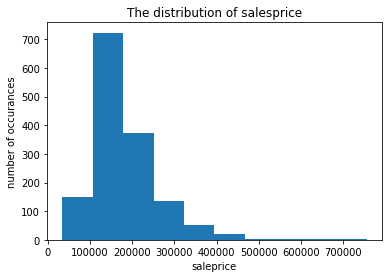

In [175]:
# get a distribution of our target variable
plt.hist(houseprices.saleprice)
plt.title("The distribution of salesprice")
plt.xlabel("saleprice")
plt.ylabel("number of occurances")
plt.show()

Our target variable is not normally distributed, it has a right skew

In [176]:
# find highest correlation of numerical features with target variable
houseprice_corr = houseprices[houseprices.columns[1:]].corr()['saleprice'][:]
print(houseprice_corr.sort_values(ascending=False))

saleprice          1.000
overallqual        0.791
grlivarea          0.709
garagecars         0.640
garagearea         0.623
totalbsmtsf        0.614
firstflrsf         0.606
fullbath           0.561
totrmsabvgrd       0.534
yearbuilt          0.523
yearremodadd       0.507
masvnrarea         0.473
has_fireplace      0.472
fireplaces         0.467
bsmtfinsf1         0.386
wooddecksf         0.324
secondflrsf        0.319
openporchsf        0.316
halfbath           0.284
lotarea            0.264
garageyrblt        0.261
has_garage         0.237
bsmtfullbath       0.227
bsmtunfsf          0.214
lotfrontage        0.210
bedroomabvgr       0.168
has_bsmt           0.150
screenporch        0.111
has_pool           0.094
poolarea           0.092
mosold             0.046
threessnporch      0.045
bsmtfinsf2        -0.011
bsmthalfbath      -0.017
miscval           -0.021
lowqualfinsf      -0.026
yrsold            -0.029
has_miscfeature   -0.072
overallcond       -0.078
mssubclass        -0.084


There are several numerical features which have a high correlation with our target variable, including overallqual, grlivarea, garagecars, garagearea, totalbsmtsf, firstflrsf, fullbath. Since several of the features have to do with sf we will create a new variable that combines those features for totalsf

In [177]:
houseprices['totalsf'] = houseprices['totalbsmtsf'] + houseprices['firstflrsf'] + houseprices['secondflrsf']


Lets explore the categorical features now

In [178]:
# create a dataframe that holds only categorical features
cat_houseprices = houseprices.select_dtypes(include=['object']).copy()

cat_houseprices.head()

,mszoning,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfintype2,heating,heatingqc,centralair,electrical,kitchenqual,functional,garagetype,garagefinish,garagequal,garagecond,paveddrive,saletype,salecondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


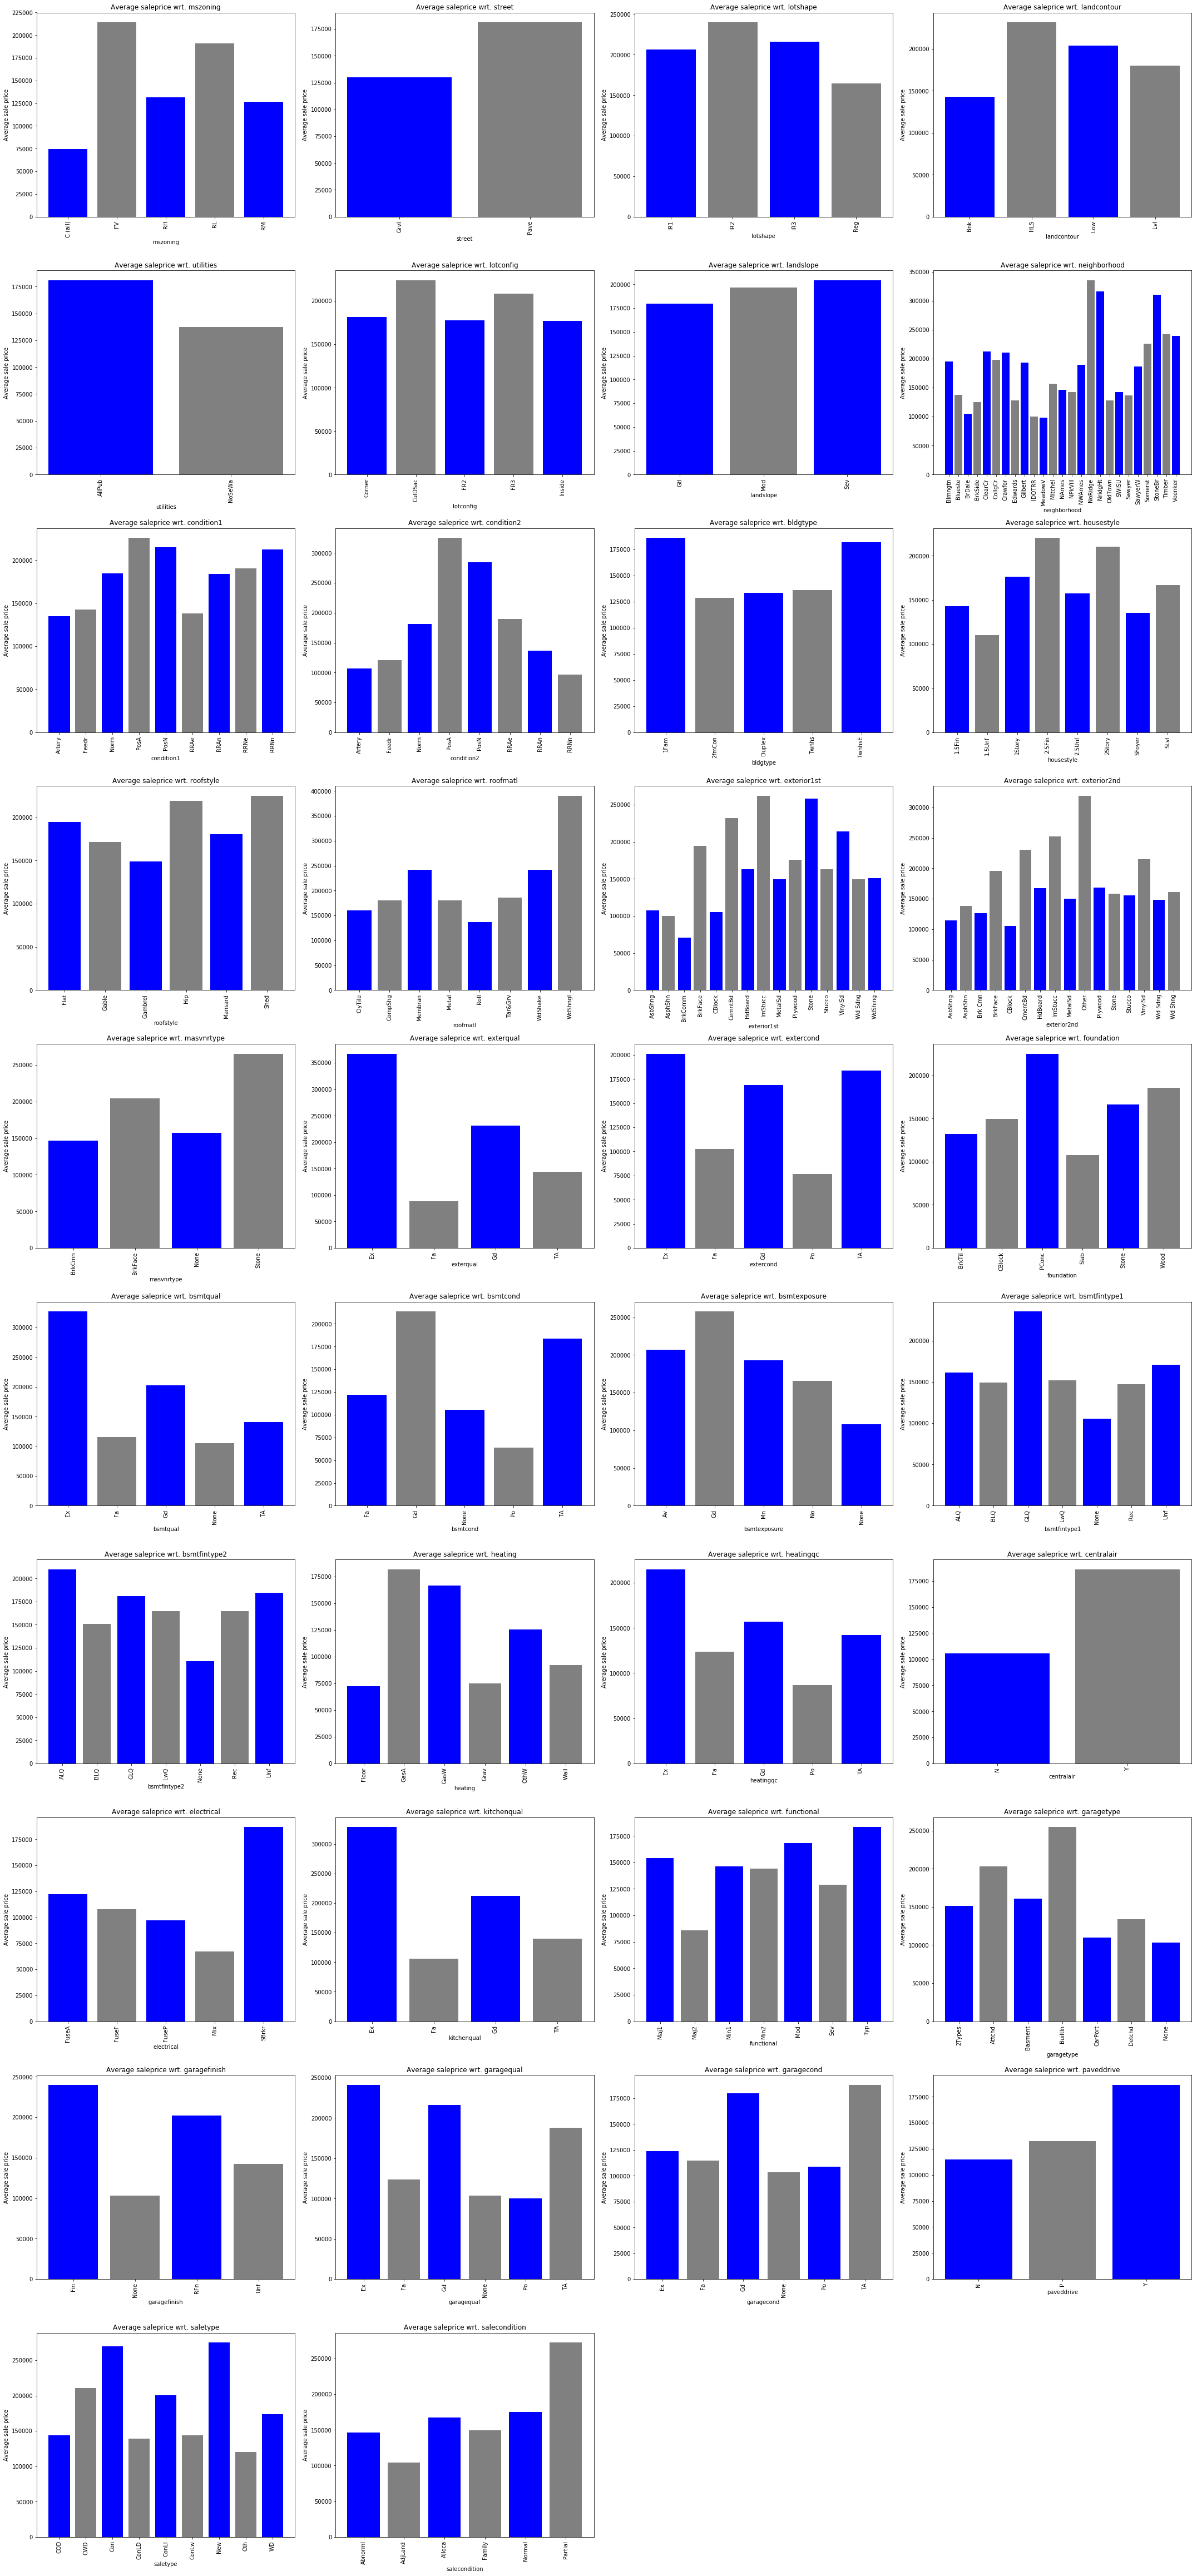

In [179]:
# plot categorical features against mean sale price to see correlation
plt.figure(figsize=(30,70))

for index, column in enumerate(cat_houseprices):
    plt.subplot(11,4,index+1)
    plt.bar(houseprices.groupby(column)["saleprice"].mean().index, houseprices.groupby(column)["saleprice"].mean(),
           color=("blue","grey"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

From the above visualizations we can see that there are many visible correlations in the categorical features. Lets take a look at mszoning, street, utilities, neighborhood, condition2, centralair, and pavedrive more closely.

In [180]:
# print value counts for interesting categorical features
print("mzzoning")
print(cat_houseprices.mszoning.value_counts())
print("street")
print(cat_houseprices.street.value_counts())
print("utilities")
print(cat_houseprices.utilities.value_counts())
print("neighborhood")
print(cat_houseprices.neighborhood.value_counts())
print("condition2")
print(cat_houseprices.condition2.value_counts())
print("centralair")
print(cat_houseprices.centralair.value_counts())
print("paveddrive")
print(cat_houseprices.paveddrive.value_counts())

mzzoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: mszoning, dtype: int64
street
Pave    1454
Grvl       6
Name: street, dtype: int64
utilities
AllPub    1459
NoSeWa       1
Name: utilities, dtype: int64
neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: neighborhood, dtype: int64
condition2
Norm      1445
Feedr        6
PosN         2
RRNn         2
Artery       2
PosA         1
RRAe         1
RRAn         1
Name: condition2, dtype: int64
centralair
Y    1365
N      95
Name: centralair, dtype: int64
paveddrive
Y    1340
N      90
P      30
Name: paveddrive, dtype: int64


Based upon the differentiation on these categorical features we will include only mszoning, and neighborhood in our model. In addition to these 2 features we will include numerical features of our comined feature for totalsf, overallqual, grlivarea, garagecars, fullbath.

First we need to turn these categorical features into dummies

In [181]:
# Build out dataframe with selected features

houseprices = pd.concat([houseprices, pd.get_dummies(houseprices.mszoning, prefix="mszoning", drop_first=True)], axis=1)
houseprices = pd.concat([houseprices, pd.get_dummies(houseprices.neighborhood, prefix="nh", drop_first=True)], axis=1)
dummy_col = list(pd.get_dummies(houseprices.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_col = dummy_col + list(pd.get_dummies(houseprices.neighborhood, prefix="nh", drop_first=True).columns)

# Models

In [182]:
# select features
X = houseprices[['overallqual', 'grlivarea', 'garagecars', 'totalsf', 'fullbath'] + dummy_col]
# select target variable
Y = houseprices.saleprice

In [183]:
# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print('The number of observations in the training set is : {}'.format(X_train.shape[0]))
print('The number of observations in the test set is : {}'.format(X_test.shape[0]))

The number of observations in the training set is : 1168
The number of observations in the test set is : 292


### OLS

In [184]:
# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# Make predictions 
y_preds_train = lrm.predict(X_train)

scores = cross_val_score(lrm, X_train, y_train, cv=5)
print(scores)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))

[0.78078457 0.87349544 0.83131717 0.69710731 0.82667583]
R-squared of the model in the training set is: 0.8168184780814481


## Lasso

In [185]:
alphas = [np.power(10.0,p) for p in np.arange(-10,25,1)]

lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

#  make predictions
y_preds_train = lasso_cv.predict(X_train)

scores = cross_val_score(lasso_cv, X_train, y_train, cv=5)
print(scores)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))

[0.78078457 0.87376395 0.83103446 0.69635351 0.82768383]
Best alpha value is: 1.0
R-squared of the model in training set is: 0.8168144008240832


## Ridge

In [186]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# make predictions
y_preds_train = ridge_cv.predict(X_train)


scores = cross_val_score(ridge_cv, X_train, y_train, cv=5)
print(scores)

# Results
print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))

[0.78078457 0.8736919  0.83201734 0.69396049 0.83086631]
Best alpha value is: 1.0
R-squared of the model in training set is: 0.8163089766362229


## ElasticNet

In [187]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

#  make predictions
y_preds_train = elasticnet_cv.predict(X_train)


scores = cross_val_score(elasticnet_cv, X_train, y_train, cv=5)
print(scores)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))

[0.78079853 0.87409398 0.83170494 0.6860091  0.8288996 ]
Best alpha value is: 0.001
R-squared of the model in training set is: 0.8165391986720489


Based upon our training set the best model will be Ordinary Least Squares as it has the highest R-squared value, however Lasso has a very similar R-squared. 

#### Evaluate Test Set on OLS

In [188]:
#evaluate OLS using test set
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.8168184780814481
-----Test set statistics-----
R-squared of the model in the test set is: 0.7739344933419964
Mean absolute error of the prediction is: 24997.407324740732
Mean squared error of the prediction is: 1517736914.187638
Root mean squared error of the prediction is: 38958.143104974064
Mean absolute percentage error of the prediction is: 14.199268604112508


It appears that our test set did not perform as well as the training set, which may be expected considering the features used may have overfit the training set.

Since housing prices are heavily influenced by mortgage rates lets add a feature that combines average interest rates with the year sold to see if we can get better performance on our model. 

I was able to get avg 30 year fixed rate mortgages from the following site http://www.freddiemac.com/pmms/pmms30.html

### Add AVG mortgage rate for yrsold

In [189]:
# find years in yrsold
houseprices.yrsold.unique()

array([2008, 2007, 2006, 2009, 2010])

In [190]:
# create function to add avg mortgage rate in new column for yrsold

def avg_rate(z):
    if z == 2006:
        return 6.41
    if z == 2007:
        return 6.34
    if z == 2008:
        return 6.03
    if z == 2009:
        return 5.04
    if z == 2010:
        return 4.69
    
# create column that imputes interest rate for yrsold
houseprices['avgmortrate'] = houseprices['yrsold'].apply(avg_rate)

In [191]:
#check our work
houseprices.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,has_pool,has_miscfeature,has_alley,has_fence,has_fireplace,has_garage,has_bsmt,totalsf,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,nh_Blueste,nh_BrDale,nh_BrkSide,nh_ClearCr,nh_CollgCr,nh_Crawfor,nh_Edwards,nh_Gilbert,nh_IDOTRR,nh_MeadowV,nh_Mitchel,nh_NAmes,nh_NPkVill,nh_NWAmes,nh_NoRidge,nh_NridgHt,nh_OldTown,nh_SWISU,nh_Sawyer,nh_SawyerW,nh_Somerst,nh_StoneBr,nh_Timber,nh_Veenker,avgmortrate
0,1,60,RL,65.000,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,0,0,0,0,0,1,1,2566,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.030
1,2,20,RL,80.000,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,0,0,0,0,1,1,1,2524,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6.340
2,3,60,RL,68.000,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,0,0,0,0,1,1,1,2706,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.030
3,4,70,RL,60.000,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,0,0,0,0,1,1,1,2473,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.410
4,5,60,RL,84.000,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,0,0,0,0,1,1,1,3343,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,6.030


Run a few more models that include avgmortrate as a feature

In [197]:
# select features
X = houseprices[['overallqual', 'grlivarea', 'garagecars', 'totalsf', 'fullbath', 'avgmortrate'] + dummy_col]
# select target variable
Y = houseprices.saleprice

# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print('The number of observations in the training set is : {}'.format(X_train.shape[0]))
print('The number of observations in the test set is : {}'.format(X_test.shape[0]))

The number of observations in the training set is : 1168
The number of observations in the test set is : 292


### OLS

In [198]:
# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# Make predictions 
y_preds_train = lrm.predict(X_train)

#evaluate OLS using test set
y_preds_test = lrm.predict(X_test)

scores = cross_val_score(lrm, X_train, y_train, cv=5)
print(scores)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

[0.78079003 0.8725864  0.83064745 0.69655207 0.82572165]
R-squared of the model in the training set is: 0.8168711453106593
-----Test set statistics-----
R-squared of the model in the test set is: 0.7737006052595133
Mean absolute error of the prediction is: 25016.983577322295
Mean squared error of the prediction is: 1519307169.5610511
Root mean squared error of the prediction is: 38978.29100359649
Mean absolute percentage error of the prediction is: 14.217318194545344


## Lasso

In [199]:
alphas = [np.power(10.0,p) for p in np.arange(-10,25,1)]

lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

#  make predictions
y_preds_train = lasso_cv.predict(X_train)

#evaluate Lasso using test set
y_preds_test = lasso_cv.predict(X_test)

scores = cross_val_score(lasso_cv, X_train, y_train, cv=5)
print(scores)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

[0.78085661 0.87292343 0.83036588 0.688898   0.8267393 ]
Best alpha value is: 1.0
R-squared of the model in training set is: 0.816867244558545
-----Test set statistics-----
R-squared of the model in the test set is: 0.7737447206373178
Mean absolute error of the prediction is: 25008.019974750026
Mean squared error of the prediction is: 1519010991.9691358
Root mean squared error of the prediction is: 38974.49155497908
Mean absolute percentage error of the prediction is: 14.216267789036074


## Ridge

In [200]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# make predictions
y_preds_train = ridge_cv.predict(X_train)

#evaluate Ridge using test set
y_preds_test = ridge_cv.predict(X_test)

scores = cross_val_score(ridge_cv, X_train, y_train, cv=5)
print(scores)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

[0.78079297 0.87279908 0.83134274 0.69333624 0.82988376]
Best alpha value is: 1.0
R-squared of the model in training set is: 0.8163593867132312
-----Test set statistics-----
R-squared of the model in the test set is: 0.7754706201269645
Mean absolute error of the prediction is: 24944.23307798432
Mean squared error of the prediction is: 1507423813.5254233
Root mean squared error of the prediction is: 38825.55619080586
Mean absolute percentage error of the prediction is: 14.288520101062263


## ElasticNet

In [201]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

#  make predictions
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

scores = cross_val_score(elasticnet_cv, X_train, y_train, cv=5)
print(scores)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

[0.78090543 0.87324011 0.83101488 0.68526466 0.82794922]
Best alpha value is: 0.001
R-squared of the model in training set is: 0.8165908514346618
-----Test set statistics-----
R-squared of the model in the test set is: 0.7748619174253577
Mean absolute error of the prediction is: 24945.175639833305
Mean squared error of the prediction is: 1511510463.3361442
Root mean squared error of the prediction is: 38878.148918591076
Mean absolute percentage error of the prediction is: 14.246600451449712


Our model showed very similar results with the new mortgage rate feature, but slightly worse than without the feature. I think there is much more we could do with mortgage rates by extrapolating total interest paid, or combining with consumer economy sentiment for those years.